In [14]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely.geometry import LineString
from scipy.interpolate import splprep, splev
from scipy.signal import savgol_filter
from collections import defaultdict
from lxml import etree

pixel_resolution = (dx, dy) = (0.125, -0.125)  # degrees per pixel (x: lon, y: lat)
lanes_and_links_gdf = gpd.read_file("test_image_1_lanes_and_links.geojson")

In [15]:
def densify(line, interval=1.0):
    n = int(line.length / interval)
    return LineString([line.interpolate(i * interval) for i in range(n + 1)])

def resample_linestring(line: LineString, spacing=0.5, smoothing=0.001):
    coords = np.array(line.coords)
    if len(coords) < 3:
        return line  # too short to refine

    # Compute arc-length parameterization
    dists = np.cumsum(np.r_[0, np.linalg.norm(np.diff(coords, axis=0), axis=1)])
    total_length = dists[-1]
    t = dists / total_length

    # Fit B-spline (low smoothing)
    try:
        tck, _ = splprep([coords[:, 0], coords[:, 1]], u=t, s=smoothing)
    except ValueError:
        return line

    # Generate resampled distances, excluding 0 and total_length
    num_pts = max(int(total_length // spacing), 1)
    mid_dists = np.linspace(spacing, total_length - spacing, num_pts - 1)
    mid_t = mid_dists / total_length

    # Evaluate spline
    x_mid, y_mid = splev(mid_t, tck)

    # Combine with endpoints
    new_coords = [tuple(coords[0])] + list(zip(x_mid, y_mid)) + [tuple(coords[-1])]
    return LineString(new_coords)


lanes_and_links_original = lanes_and_links_gdf.copy()
lanes_and_links_refined = lanes_and_links_gdf.copy()

# Densify before spline
lanes_and_links_refined['geometry'] = lanes_and_links_refined['geometry'].apply(lambda l: densify(l, interval=1.0))

# Resample using low-smoothing spline
lanes_and_links_refined['geometry'] = lanes_and_links_refined['geometry'].apply(lambda l: resample_linestring(l, spacing=0.5, smoothing=100))


Text(0.5, 1.0, 'Refined Lanes and Links')

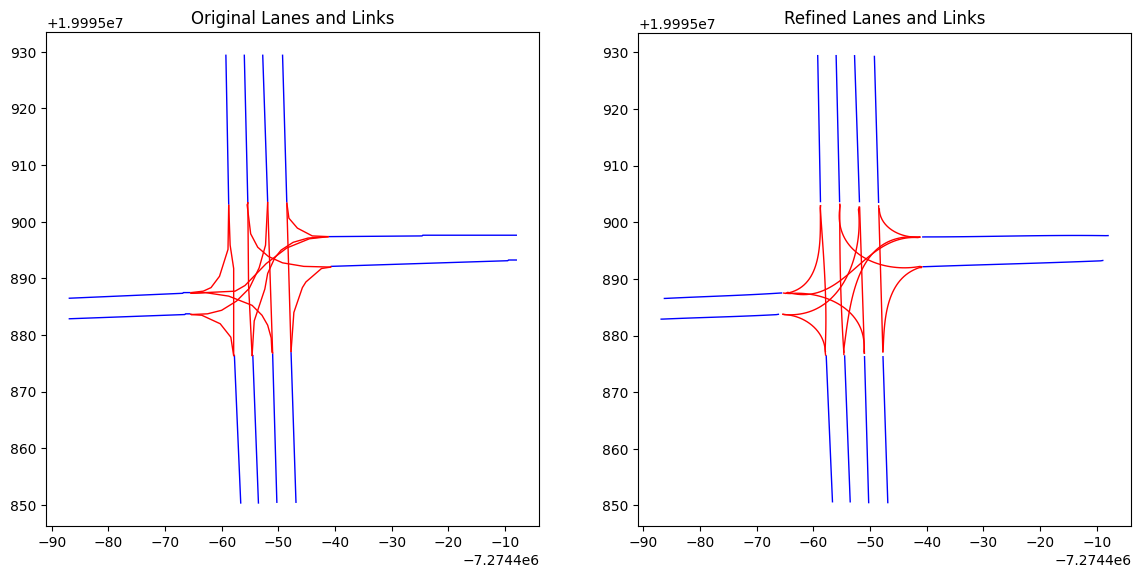

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

lanes_and_links_original[lanes_and_links_gdf['type'] == 'lane'].plot(ax=axs[0], color='blue', linewidth=1, label='lanes')
lanes_and_links_original[lanes_and_links_gdf['type'] == 'link'].plot(ax=axs[0], color='red', linewidth=1, label='links')
axs[0].set_title('Original Lanes and Links')


lanes_and_links_refined[lanes_and_links_refined['type'] == 'lane'].plot(ax=axs[1], color='blue', linewidth=1, label='lanes')
lanes_and_links_refined[lanes_and_links_refined['type'] == 'link'].plot(ax=axs[1], color='red', linewidth=1, label='links')
axs[1].set_title('Refined Lanes and Links')

/tmp/ipykernel_24082/143431349.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = cm.get_cmap(cmap, num_ids)


<Axes: title={'center': 'Lane Groups'}>

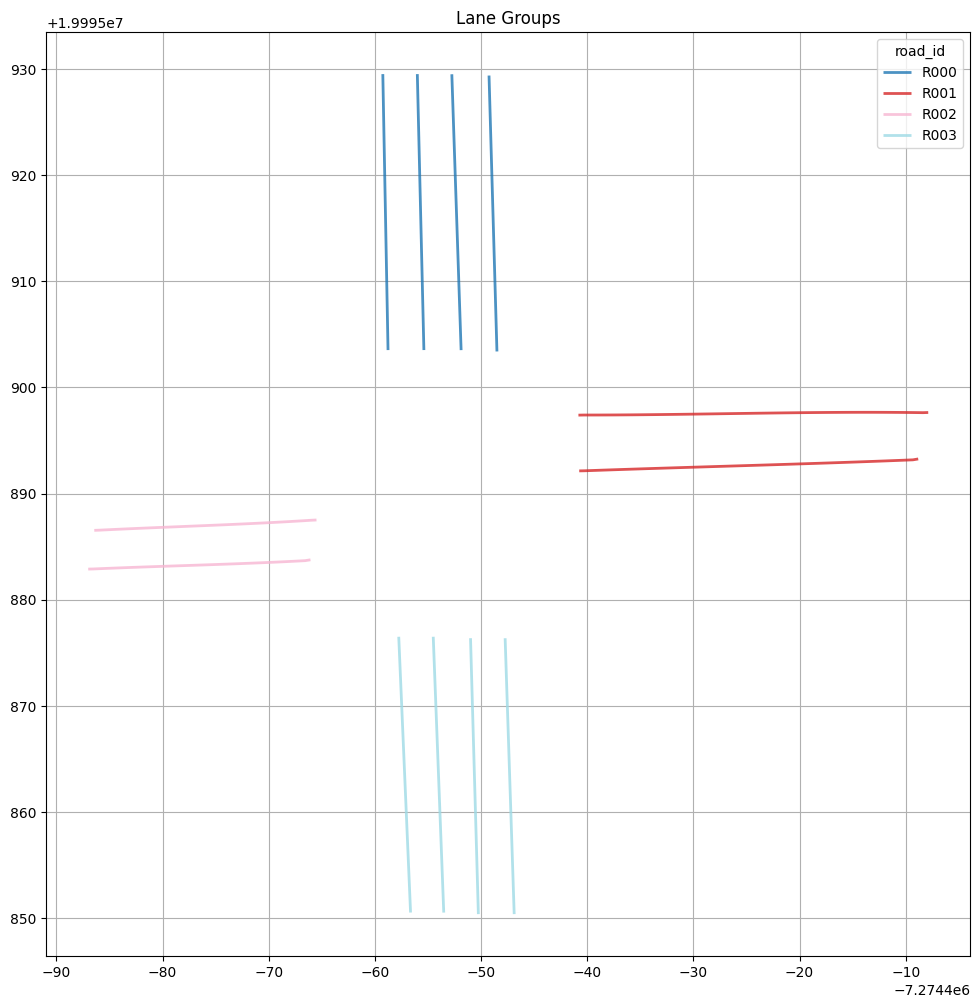

In [17]:

def resample_line_spacing(line: LineString, spacing=0.5):
    length = line.length
    if length < spacing:
        return line
    n = int(length // spacing) + 2
    return LineString([line.interpolate(d) for d in np.linspace(0, length, n)])

def lines_are_similar(line1: LineString, line2: LineString, tolerance=3.0):
    return line1.hausdorff_distance(line2) < tolerance

def group_lanes_by_geometry(gdf_lanes, spacing=0.5, tolerance=3.0):
    gdf_lanes = gdf_lanes[gdf_lanes["type"] == "lane"].copy().reset_index(drop=True)
    gdf_lanes["geometry_resampled"] = gdf_lanes["geometry"].apply(lambda g: resample_line_spacing(g, spacing=spacing))

    # Union-Find setup
    parent = {}

    def find(x):
        while parent.get(x, x) != x:
            x = parent[x]
        return x

    def union(x, y):
        parent[find(x)] = find(y)

    # Compare all lane pairs
    for i in range(len(gdf_lanes)):
        for j in range(i + 1, len(gdf_lanes)):
            li = gdf_lanes.loc[i, "geometry_resampled"]
            lj = gdf_lanes.loc[j, "geometry_resampled"]
            if lines_are_similar(li, lj, tolerance=tolerance):
                union(i, j)

    # Assign road IDs
    groups = defaultdict(list)
    for i in range(len(gdf_lanes)):
        gid = find(i)
        groups[gid].append(i)

    index_to_road_id = {}
    for idx, (gid, members) in enumerate(groups.items()):
        road_id = f"R{idx:03d}"
        for m in members:
            index_to_road_id[m] = road_id

    gdf_lanes["road_id"] = gdf_lanes.index.map(index_to_road_id)
    return gdf_lanes.drop(columns=["geometry_resampled"])


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

def visualize_road_groups(gdf_lanes, ax=None, cmap='tab20'):
    """
    Visualize grouped lanes with different colors based on road_id.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    unique_ids = sorted(gdf_lanes["road_id"].unique())
    num_ids = len(unique_ids)

    # Create color map
    cmap_obj = cm.get_cmap(cmap, num_ids)
    color_map = {rid: mcolors.to_hex(cmap_obj(i)) for i, rid in enumerate(unique_ids)}

    # Plot each group
    for rid in unique_ids:
        group = gdf_lanes[gdf_lanes["road_id"] == rid]
        group.plot(ax=ax, color=color_map[rid], label=rid, linewidth=2, alpha=0.8)

    ax.set_title("Lane Groups")
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend(loc='best', title="road_id")

    return ax

gdf_links = lanes_and_links_refined[lanes_and_links_refined["type"] == "link"]
gdf_lanes = group_lanes_by_geometry(lanes_and_links_refined[lanes_and_links_refined["type"] == "lane"], spacing=0.5, tolerance=8.0)

visualize_road_groups(gdf_lanes)

/tmp/ipykernel_24082/274504104.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = cm.get_cmap(cmap, num_ids)


<Axes: title={'center': 'Road Groups with Reference Lines'}>

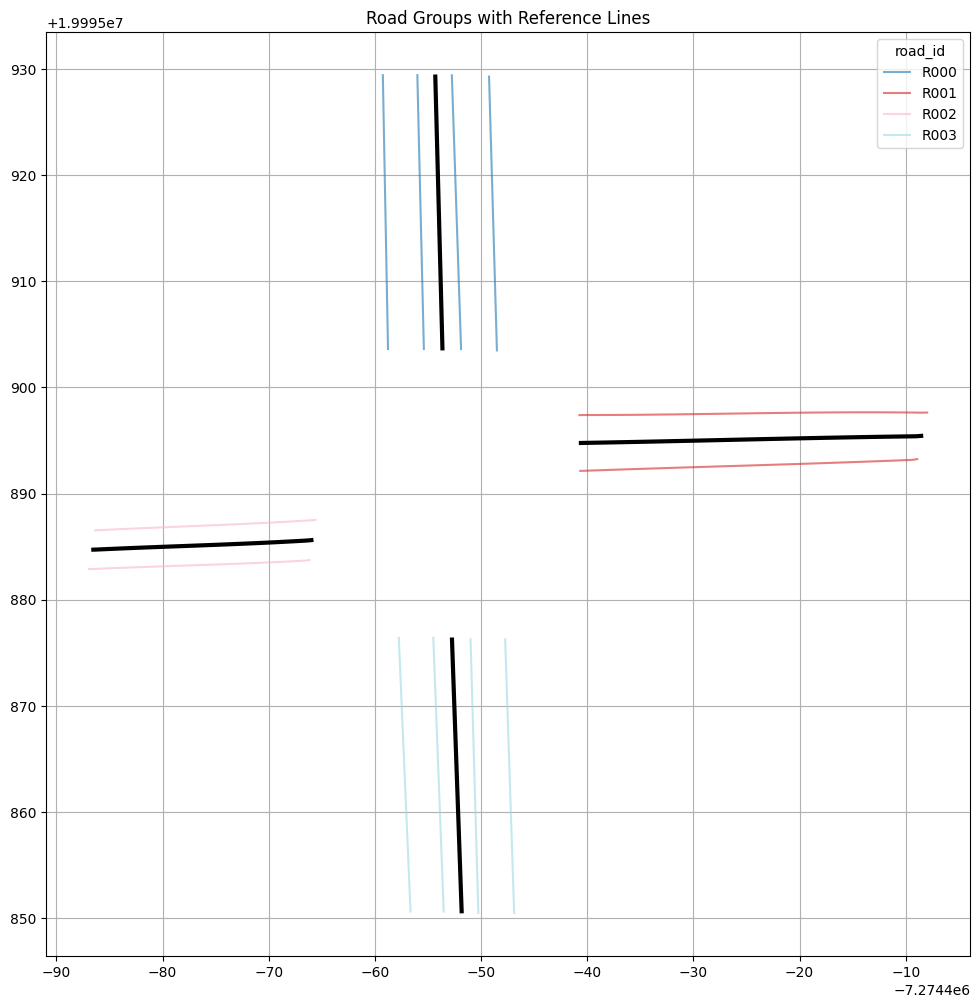

In [18]:
def resample_line_points(line, num_points=50):
    """Uniformly sample a fixed number of points along the line."""
    return np.array([[pt.x, pt.y] for pt in [line.interpolate(d) for d in np.linspace(0, line.length, num_points)]])


def compute_reference_lines_per_group_direction_aware(gdf_lanes, num_points=50):
    """
    Compute direction-aligned average reference line for each road group.
    Returns: dict {road_id: LineString}
    """
    ref_lines = {}

    for road_id, group in gdf_lanes.groupby("road_id"):
        sampled_lines = []

        # Reference: first lane
        ref_coords = resample_line_points(group.iloc[0].geometry, num_points=num_points)

        for geom in group["geometry"]:
            coords = resample_line_points(geom, num_points=num_points)

            # Flip if direction doesn't match reference (check start-end distance)
            d_forward = np.linalg.norm(ref_coords[0] - coords[0])
            d_reverse = np.linalg.norm(ref_coords[0] - coords[-1])

            if d_reverse < d_forward:
                coords = coords[::-1]  # reverse

            sampled_lines.append(coords)

        # Average all coordinates
        avg_coords = np.mean(np.stack(sampled_lines), axis=0)
        ref_lines[road_id] = LineString(avg_coords)
    return ref_lines


def visualize_road_groups_with_reference_lines(gdf_lanes, ref_lines, ax=None, cmap='tab20'):
    """
    Visualize road_id groups in color, and overlay reference lines in bold black.
    
    Parameters:
        gdf_lanes: GeoDataFrame with 'road_id' and 'geometry'
        ref_lines: dict {road_id: LineString}
    """
    import geopandas as gpd
    from shapely.geometry import LineString

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    unique_ids = sorted(gdf_lanes["road_id"].unique())
    num_ids = len(unique_ids)

    cmap_obj = cm.get_cmap(cmap, num_ids)
    color_map = {rid: mcolors.to_hex(cmap_obj(i)) for i, rid in enumerate(unique_ids)}

    # Plot each lane group
    for rid in unique_ids:
        group = gdf_lanes[gdf_lanes["road_id"] == rid]
        group.plot(ax=ax, color=color_map[rid], linewidth=1.5, label=rid, alpha=0.6)

    # Plot each reference line in black
    for rid, ref_geom in ref_lines.items():
        gpd.GeoSeries([ref_geom]).plot(ax=ax, color='black', linewidth=3, zorder=10)

    ax.set_title("Road Groups with Reference Lines")
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend(loc='best', title="road_id")

    return ax


ref_lines = compute_reference_lines_per_group_direction_aware(gdf_lanes)
gdf_lanes["reference_geom"] = gdf_lanes["road_id"].map(ref_lines)
visualize_road_groups_with_reference_lines(gdf_lanes, ref_lines)

In [19]:
def compute_signed_offset(ref_pts, lane_pts):
    """
    Compute average signed lateral offset of lane_pts from ref_pts.
    Assumes same number of points and similar alignment.
    """
    offsets = []
    for i in range(len(ref_pts) - 1):
        # Vector along ref line
        dx, dy = ref_pts[i+1] - ref_pts[i]
        norm = np.sqrt(dx**2 + dy**2)
        if norm == 0:
            continue
        # Normal vector (left side of road)
        nx, ny = -dy / norm, dx / norm
        # Vector to lane
        lx, ly = lane_pts[i] - ref_pts[i]
        offset = lx * nx + ly * ny  # signed distance
        offsets.append(offset)
    return np.mean(offsets)

def assign_lane_ids_per_group(gdf_lanes, ref_lines, num_points=50):
    """
    Assign OpenDRIVE-compliant lane IDs (+1, -1, etc.) based on signed lateral offset.
    No flipping of geometry is done here.
    """
    gdf_lanes = gdf_lanes.copy()

    for road_id, group in gdf_lanes.groupby("road_id"):
        ref_line = ref_lines[road_id]
        ref_pts = np.array([[pt.x, pt.y] for pt in [ref_line.interpolate(d) for d in np.linspace(0, ref_line.length, num_points)]])

        lane_offsets = []

        for idx, row in group.iterrows():
            line = row.geometry
            lane_pts = np.array([[pt.x, pt.y] for pt in [line.interpolate(d) for d in np.linspace(0, line.length, num_points)]])

            # No flipping — just compute signed lateral offset
            signed_offset = compute_signed_offset(ref_pts, lane_pts)
            lane_offsets.append((idx, signed_offset))

        # Sort by offset
        # sorted_lanes = sorted(lane_offsets, key=lambda x: x[1])
        # sort the positive and negative offsets separately
        sorted_lanes = sorted(lane_offsets, key=lambda x: (x[1] < 0, abs(x[1])))
        

        lane_id_map = {}
        current_left = -1
        current_right = 1

        for idx, offset in sorted_lanes:
            if offset < 0:
                lane_id_map[idx] = (current_left, "left")
                current_left -= 1
            else:
                lane_id_map[idx] = (current_right, "right")
                current_right += 1

        for idx, (lid, side) in lane_id_map.items():
            gdf_lanes.at[idx, "lane_id"] = lid
            gdf_lanes.at[idx, "lane_side"] = side

    return gdf_lanes

gdf_lanes = assign_lane_ids_per_group(gdf_lanes, ref_lines)

In [20]:

def compute_avg_lateral_offsets(gdf_lanes, ref_lines, num_points=50):
    """
    Compute average signed lateral offset from each lane centerline to its reference line.
    Adds: 'avg_offset' column to the GeoDataFrame.
    """
    gdf_lanes = gdf_lanes.copy()
    offsets = []

    for idx, row in gdf_lanes.iterrows():
        road_id = row["road_id"]
        lane_line = row["geometry"]
        ref_line = ref_lines[road_id]

        lane_pts = resample_line_points(lane_line, num_points=num_points)
        ref_pts = resample_line_points(ref_line, num_points=num_points)

        signed_dists = []
        for i in range(len(ref_pts) - 1):
            # Reference direction vector
            p0 = ref_pts[i]
            p1 = ref_pts[i + 1]
            t = p1 - p0
            t_norm = np.linalg.norm(t)
            if t_norm < 1e-6:
                continue
            t_unit = t / t_norm
            n = np.array([-t_unit[1], t_unit[0]])  # left-hand normal

            # Corresponding lane point
            q = lane_pts[i]

            # Vector from ref point to lane point
            v = q - p0
            signed_dist = np.dot(v, n)  # projection onto normal
            signed_dists.append(signed_dist)

        avg_offset = np.mean(signed_dists)
        offsets.append(avg_offset)

    gdf_lanes["avg_offset"] = offsets
    return gdf_lanes


def assign_lane_widths_and_offsets(gdf_lanes_with_offsets):
    gdf = gdf_lanes_with_offsets.copy()
    gdf["lane_width"] = 0.0
    gdf["lane_offset"] = 0.0

    for road_id, group in gdf.groupby("road_id"):
        # LEFT lanes (avg_offset < 0): more negative = farther from center
        left_lanes = group[group["lane_side"] == "left"].copy()
        left_lanes = left_lanes.sort_values("avg_offset", ascending=False)

        offset_acc = 0.0
        for idx, row in left_lanes.iterrows():
            center = row["avg_offset"]
            width = 2 * abs(abs(center) - offset_acc)
            gdf.at[idx, "lane_width"] = width
            gdf.at[idx, "lane_offset"] = offset_acc
            offset_acc += width

        # RIGHT lanes (avg_offset > 0): closer to 0 = inner lane
        right_lanes = group[group["lane_side"] == "right"].copy()
        right_lanes = right_lanes.sort_values("avg_offset")  # from 1.8 → 5.4

        offset_acc = 0.0
        for idx, row in right_lanes.iterrows():
            center = row["avg_offset"]
            width = 2 * abs(center - offset_acc)
            gdf.at[idx, "lane_width"] = width
            gdf.at[idx, "lane_offset"] = offset_acc
            offset_acc += width

    return gdf


gdf_lanes = compute_avg_lateral_offsets(gdf_lanes, ref_lines)
gdf_lanes = assign_lane_widths_and_offsets(gdf_lanes)


In [21]:
def enrich_links_with_road_ids(gdf_links, gdf_lanes):
    """
    For each link, map from_fid and to_fid to the road_id of the corresponding lanes.
    """
    fid_to_road = gdf_lanes.set_index("fid")["road_id"].to_dict()
    fid_to_lane_id = gdf_lanes.set_index("fid")["lane_id"].to_dict()

    gdf_links = gdf_links.copy()
    gdf_links["incoming_road_id"] = gdf_links["from_fid"].map(fid_to_road)
    gdf_links["outgoing_road_id"] = gdf_links["to_fid"].map(fid_to_road)
    gdf_links["from_lane_id"] = gdf_links["from_fid"].map(fid_to_lane_id)
    gdf_links["to_lane_id"] = gdf_links["to_fid"].map(fid_to_lane_id)

    return gdf_links


def determine_lane_side(ref_line: LineString, lane_line: LineString) -> str:
    """Determine if lane is on 'left' or 'right' of the reference line."""
    # Sample 3 points to avoid instability
    num_points = 3
    ref_pts = np.linspace(0, ref_line.length, num=num_points)
    lane_pts = np.linspace(0, lane_line.length, num=num_points)

    offset_sum = 0
    for s in range(num_points - 1):
        r = np.array(ref_line.interpolate(ref_pts[s]).coords[0])
        r_next = np.array(ref_line.interpolate(ref_pts[s+1]).coords[0])
        l = np.array(lane_line.interpolate(lane_pts[s]).coords[0])

        vec = r_next - r
        norm = np.linalg.norm(vec)
        if norm == 0:
            continue
        tangent = vec / norm
        normal = np.array([-tangent[1], tangent[0]])  # left-hand normal

        diff = l - r
        offset = np.dot(diff, normal)
        offset_sum += offset

    return "left" if offset_sum > 0 else "right"


def compute_angle(v1, v2):
    """Compute angle in degrees between two vectors, safely."""
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0
    cos_theta = np.dot(v1, v2) / (norm_v1 * norm_v2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    return np.degrees(np.arccos(cos_theta))

def shift_linestring(line: LineString, offset: float, angle_thresh=10, smooth_window=10, polyorder=2) -> LineString:
    coords = np.asarray(line.coords)
    if len(coords) < 2:
        return line

    start_pt = coords[0]
    end_pt = coords[-1]

    valid_idx = []
    for i in range(1, len(coords) - 1):
        v1 = coords[i] - coords[i - 1]
        v2 = coords[i + 1] - coords[i]
        angle = compute_angle(v1, v2)
        if angle <= angle_thresh:
            valid_idx.append(i)

    if not valid_idx:
        return LineString([start_pt, end_pt])  # only endpoints remain

    # Always keep endpoints
    keep_indices = [0] + valid_idx + [len(coords) - 1]

    shifted_coords = []
    for i in keep_indices:
        if i == 0:
            vec = coords[1] - coords[0]
        elif i == len(coords) - 1:
            vec = coords[-1] - coords[-2]
        else:
            vec = coords[i + 1] - coords[i - 1]

        norm = np.linalg.norm(vec)
        if norm == 0:
            shifted_coords.append(coords[i])
            continue
        tangent = vec / norm
        normal = np.array([-tangent[1], tangent[0]])
        shifted_coords.append(coords[i] + offset * normal)

    shifted_coords = np.array(shifted_coords)

    # Smoothing
    if len(shifted_coords) >= smooth_window:
        try:
            x_smooth = savgol_filter(shifted_coords[:, 0], smooth_window, polyorder)
            y_smooth = savgol_filter(shifted_coords[:, 1], smooth_window, polyorder)
            shifted_coords = np.column_stack([x_smooth, y_smooth])
        except Exception as e:
            print(f"[WARN] Savitzky-Golay smoothing failed: {e}")

    return LineString(shifted_coords)



def enrich_links_with_lane_geometry(gdf_links, gdf_lanes):
    """
    Update gdf_links in-place: estimate lane width/offset/side/lane_id, assign road_id, compute reference_geom.
    Lane side is computed using OpenDRIVE geometric convention.
    """
    # Lookup lane widths
    fid2width = gdf_lanes.set_index("fid")["lane_width"].to_dict()

    lane_widths, lane_offsets, lane_sides = [], [], []
    road_ids, ref_lines, lane_ids = [], [], []

    for idx, row in gdf_links.iterrows():
        from_fid = row["from_fid"]
        to_fid = row["to_fid"]

        w1 = fid2width.get(from_fid, 3.5)
        w2 = fid2width.get(to_fid, 3.5)
        avg_width = (w1 + w2) / 2

        center_line = row["geometry"]
        offset = avg_width / 2  # magnitude only for now

        # Estimate reference line (shift toward right, guess)
        ref_guess = shift_linestring(center_line, -offset)

        # Determine left/right using standard
        side = determine_lane_side(ref_guess, center_line)

        # Correct ref_line shift based on actual side
        signed_offset = offset if side == "left" else -offset
        ref_line = shift_linestring(center_line, signed_offset)

        lane_id = -1 if side == "left" else 1

        lane_widths.append(avg_width)
        lane_offsets.append(signed_offset)
        lane_sides.append(side)
        lane_ids.append(lane_id)
        road_ids.append(f"L{idx:03d}")
        ref_lines.append(ref_line)

    gdf_links["lane_width"] = lane_widths
    gdf_links["lane_offset"] = lane_offsets
    gdf_links["lane_side"] = lane_sides
    gdf_links["lane_id"] = lane_ids
    gdf_links["road_id"] = road_ids
    gdf_links["reference_geom"] = ref_lines

    return gdf_links



def enrich_links_with_lane_geometry(gdf_links, gdf_lanes):
    """
    Update gdf_links in-place: estimate lane width/offset/side/lane_id, assign road_id, compute reference_geom.
    Lane side is computed using OpenDRIVE geometric convention.
    """
    # Lookup lane widths
    fid2width = gdf_lanes.set_index("fid")["lane_width"].to_dict()

    lane_widths, lane_offsets, lane_sides = [], [], []
    road_ids, ref_lines, lane_ids = [], [], []

    for idx, row in gdf_links.iterrows():
        from_fid = row["from_fid"]
        to_fid = row["to_fid"]

        w1 = fid2width.get(from_fid, 3.5)
        w2 = fid2width.get(to_fid, 3.5)
        avg_width = (w1 + w2) / 2

        center_line = row["geometry"]
        offset = avg_width / 2  # magnitude only for now

        # Estimate reference line (shift toward right, guess)
        ref_guess = shift_linestring(center_line, -offset)

        # Determine left/right using standard
        side = determine_lane_side(ref_guess, center_line)

        # Correct ref_line shift based on actual side
        signed_offset = offset if side == "left" else -offset
        ref_line = shift_linestring(center_line, signed_offset)

        lane_id = -1 if side == "left" else 1

        lane_widths.append(avg_width)
        lane_offsets.append(signed_offset)
        lane_sides.append(side)
        lane_ids.append(lane_id)
        road_ids.append(f"L{idx:03d}")
        ref_lines.append(ref_line)

    gdf_links["lane_width"] = lane_widths
    gdf_links["lane_offset"] = lane_offsets
    gdf_links["lane_side"] = lane_sides
    gdf_links["lane_id"] = lane_ids
    gdf_links["road_id"] = road_ids
    gdf_links["reference_geom"] = ref_lines

    return gdf_links

gdf_links = enrich_links_with_road_ids(gdf_links, gdf_lanes)
gdf_links = enrich_links_with_lane_geometry(gdf_links, gdf_lanes)

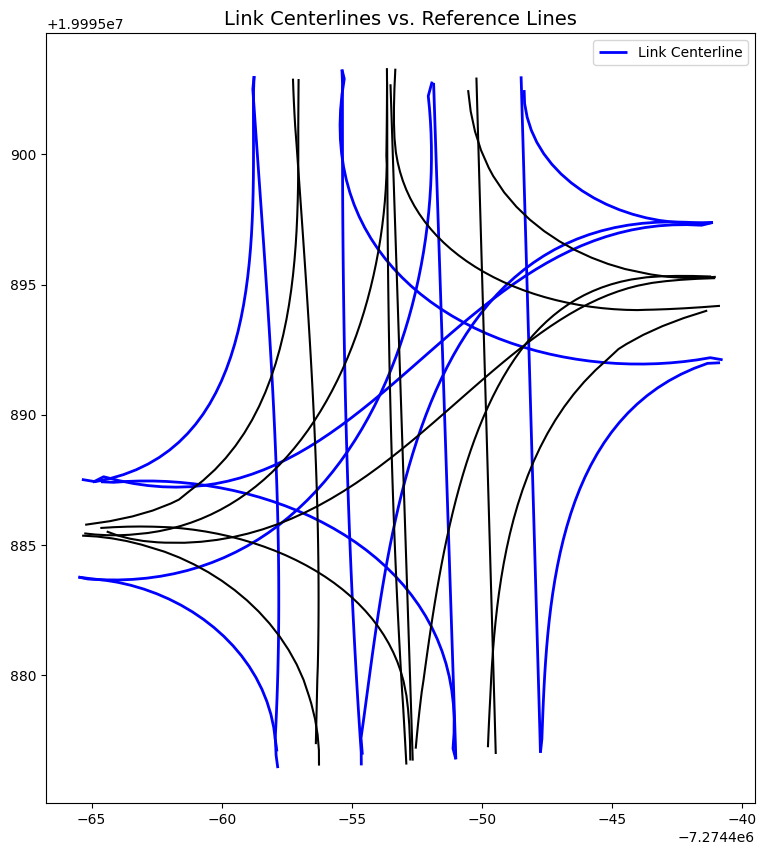

In [22]:
def visualize_links_with_ref_lines(gdf_links, figsize=(10, 10), save_path=None):
    """
    Visualize link centerlines and their generated reference lines.
    - Link geometry (centerline): solid blue
    - Reference line (OpenDRIVE planView): dashed red
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Plot all centerlines
    gdf_links.plot(ax=ax, color='blue', linewidth=2, label='Link Centerline')

    # Plot reference lines if available
    for idx, row in gdf_links.iterrows():
        if "reference_geom" in row and row["reference_geom"] is not None:
            ref_line = row["reference_geom"]
            gpd.GeoSeries([ref_line]).plot(ax=ax, color='black', linewidth=1.5, label='Reference Line' if idx == 0 else "")

    # Annotations and legend
    ax.set_title("Link Centerlines vs. Reference Lines", fontsize=14)
    ax.set_aspect("equal")
    ax.legend(loc="upper right")

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"[✓] Saved to {save_path}")
    else:
        plt.show()
visualize_links_with_ref_lines(gdf_links)

In [23]:
def calculate_heading(p0, p1):
    dx, dy = p1[0] - p0[0], p1[1] - p0[1]
    return np.arctan2(dy, dx)

def generate_road_element(road_id, ref_line: LineString, gdf_lanes, gdf_links, junction_id="-1"):
    """
    Generate a complete <road> OpenDRIVE element, including planView, lanes, and topological <link>.

    Parameters:
    - road_id: ID of the road to generate.
    - ref_line: Centerline geometry as shapely LineString.
    - gdf_lanes: GeoDataFrame of lane segments (non-link roads).
    - gdf_links: GeoDataFrame of connecting roads with predecessor/successor fields.
    - junction_id: ID of the junction this road belongs to (default: -1 for standalone roads).
    """
    
    
    road_elem = etree.Element("road", id=str(road_id), name=str(road_id), length=f"{ref_line.length:.3f}", junction=str(junction_id))

    # Add <link> block for topological connectivity
    link_elem = etree.SubElement(road_elem, "link")
    
    fid_to_road_id_lanes = gdf_lanes.set_index("fid")["road_id"].to_dict()
    fid_to_road_id_links = gdf_links.set_index("fid")["road_id"].to_dict()
    fid_to_road_id = {**fid_to_road_id_lanes, **fid_to_road_id_links}

    is_link = False
    if road_id in gdf_links["road_id"].values:
        is_link = True
        road_data_row = gdf_links[gdf_links["road_id"] == road_id].iloc[0]
    elif road_id in gdf_lanes["road_id"].values:
        is_link = False
        road_data_row = gdf_lanes[gdf_lanes["road_id"] == road_id].iloc[0]
    else:
        # if the road id is invalid, raise exception
        raise ValueError(f"Invalid road_id: {road_id}. It does not exist in gdf_lanes or gdf_links.")
    

    pred_fid = road_data_row.get("from_fid")
    succ_fid = road_data_row.get("to_fid")
    pred_road_id = fid_to_road_id.get(pred_fid)
    succ_road_id = fid_to_road_id.get(succ_fid)
    if pd.notna(pred_road_id):
        etree.SubElement(link_elem, "predecessor", elementType="road", elementId=str(pred_road_id), contactPoint="end")
    if pd.notna(succ_road_id):
        etree.SubElement(link_elem, "successor", elementType="road", elementId=str(succ_road_id), contactPoint="start")

    # --- planView ---
    planview = etree.SubElement(road_elem, "planView")
    coords = list(ref_line.coords)
    s = 0.0
    for i in range(len(coords) - 1):
        x, y = coords[i]
        x2, y2 = coords[i+1]
        hdg = calculate_heading(coords[i], coords[i+1])
        seg_length = LineString([coords[i], coords[i+1]]).length
        geometry = etree.SubElement(planview, "geometry", s=f"{s:.3f}", x=f"{x:.6f}", y=f"{y:.6f}",
                                    hdg=f"{hdg:.6f}", length=f"{seg_length:.6f}")
        etree.SubElement(geometry, "line")
        s += seg_length

    # --- lanes ---
    lanes_elem = etree.SubElement(road_elem, "lanes")
    lane_section = etree.SubElement(lanes_elem, "laneSection", s="0.0")

    left_elem = etree.SubElement(lane_section, "left")
    right_elem = etree.SubElement(lane_section, "right")
    center_elem = etree.SubElement(lane_section, "center")
    etree.SubElement(center_elem, "lane", id="0", type="none", level="true")

    if is_link:
        lanes_to_add = gdf_links[gdf_links["road_id"] == road_id]
    else:
        lanes_to_add = gdf_lanes[gdf_lanes["road_id"] == road_id]

    for _, row in lanes_to_add.iterrows():
        lane_el = etree.Element("lane", id=str(int(row["lane_id"])), type="driving", level="true")
        etree.SubElement(
            lane_el, "width", sOffset="0.000",
            a=f"{row['lane_width']:.3f}", b="0.0", c="0.0", d="0.0"
        )
        if row["lane_side"] == "left":
            left_elem.append(lane_el)
        else:
            right_elem.append(lane_el)

    return road_elem
def generate_junctions_from_links(gdf_links, junction_id="0"):
    """
    Generate <junction> elements from enriched link GeoDataFrame.
    Assumes gdf_links has columns:
    ['fid', 'incoming_road_id', 'outgoing_road_id', 'from_lane_id', 'to_lane_id']
    """
    junction_elem = etree.Element("junction", id=junction_id, type="default")

    for idx, row in gdf_links.iterrows():
        # Create <connection> element
        conn = etree.SubElement(
            junction_elem, "connection",
            id=str(row["fid"]),
            incomingRoad=str(row["incoming_road_id"]),
            connectingRoad=str(row["fid"]),
            contactPoint="start"
        )

        # Add <laneLink>
        from_lane = str(int(row["from_lane_id"])) if pd.notna(row["from_lane_id"]) else "0"
        to_lane = str(int(row["to_lane_id"])) if pd.notna(row["to_lane_id"]) else "0"

        etree.SubElement(conn, "laneLink", from_=from_lane, to=to_lane)

    return junction_elem

def generate_opendrive(gdf_lanes, gdf_links, filename="output.xodr", proj_string=None):
    """
    Generate a full OpenDRIVE .xodr file from all road groups in gdf_lanes.
    Optionally injects a <geoReference> tag.
    """
    root = etree.Element("OpenDRIVE")

    # Optional: add geoReference block
    if proj_string:
        user_data = etree.SubElement(root, "userData")
        etree.SubElement(user_data, "geoReference").text = proj_string

    lane_ref_lines = {road_id: row['reference_geom'] for road_id, row in gdf_lanes.groupby("road_id").first().iterrows()}
    for road_id, group in gdf_lanes.groupby("road_id"):
        ref_line = lane_ref_lines.get(road_id)
        if ref_line is None:
            print(f"[WARN] No reference line for road {road_id}")
            continue
        print(f"[INFO] Generating road {road_id} with {len(group)} lanes")
        road_elem = generate_road_element(road_id, ref_line, gdf_lanes, gdf_links, junction_id=f"J{0:03d}")
        root.append(road_elem)

    link_ref_lines = {road_id: row['reference_geom'] for road_id, row in gdf_links.groupby("road_id").first().iterrows()}
    for road_id, group in gdf_links.groupby("road_id"):
        ref_line = link_ref_lines.get(road_id)
        if ref_line is None:
            print(f"[WARN] No reference line for road {road_id}")
            continue
        print(f"[INFO] Generating road {road_id} with {len(group)} lanes")
        road_elem = generate_road_element(road_id, ref_line, gdf_lanes, gdf_links, junction_id=f"J{0:03d}")
        root.append(road_elem)

    # Generate junctions from links
    if not gdf_links.empty:
        print(f"[INFO] Generating junctions from {len(gdf_links)} links")
        junction_elem = generate_junctions_from_links(gdf_links, junction_id=f"J{0:03d}")
        root.append(junction_elem)
    
    # Write to file
    tree = etree.ElementTree(root)
    tree.write(filename, pretty_print=True, xml_declaration=True, encoding="UTF-8")
    print(f"OpenDRIVE file saved to: {filename}")

def get_proj4_from_crs(gdf):
    if gdf.crs is None:
        raise ValueError("GeoDataFrame has no CRS set.")
    return gdf.crs.to_proj4()
utm_proj = get_proj4_from_crs(gdf_lanes)
generate_opendrive(gdf_lanes, gdf_links, filename="extracted_opendrive_map.xodr", proj_string=utm_proj)


[INFO] Generating road R000 with 4 lanes
[INFO] Generating road R001 with 2 lanes
[INFO] Generating road R002 with 2 lanes
[INFO] Generating road R003 with 4 lanes
[INFO] Generating road L001 with 1 lanes
[INFO] Generating road L002 with 1 lanes
[INFO] Generating road L004 with 1 lanes
[INFO] Generating road L005 with 1 lanes
[INFO] Generating road L008 with 1 lanes
[INFO] Generating road L009 with 1 lanes
[INFO] Generating road L010 with 1 lanes
[INFO] Generating road L015 with 1 lanes
[INFO] Generating road L016 with 1 lanes
[INFO] Generating road L017 with 1 lanes
[INFO] Generating road L018 with 1 lanes
[INFO] Generating road L020 with 1 lanes
[INFO] Generating road L021 with 1 lanes
[INFO] Generating junctions from 13 links
OpenDRIVE file saved to: extracted_opendrive_map.xodr


/home/hetianguo/miniconda3/envs/MP/lib/python3.9/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
